1. Installing required modules

In [1]:
# Install required modules
!pip install datasets
!pip install transformers
!pip install umap-learn

     |████████████████████████████████| 312 kB 4.1 MB/s 
     |████████████████████████████████| 134 kB 78.8 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 66.3 MB/s 
     |████████████████████████████████| 212 kB 70.2 MB/s 
     |████████████████████████████████| 127 kB 79.3 MB/s 
     |████████████████████████████████| 271 kB 71.0 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
     |████████████████████████████████| 144 kB 60.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 3.9 MB/s 


2. Import required modules

In [2]:
# Import required modules
from datasets import load_dataset, DatasetDict, Features, Value, ClassLabel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

3. Mounting google drive for accessing dataset files

In [3]:
# Mounting google drive for accessing dataset files
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


4. Creating the dataset

In [4]:
# Creating the dataset
train_file = "/content/drive/MyDrive/2022/College/COMP6321/data/train_dataset_cleaned.csv"
test_file = "/content/drive/MyDrive/2022/College/COMP6321/data/test_dataset_cleaned.csv"

data_files = {"train": train_file, "test": test_file}
class_names = ["negative", "neutral", "positive"]
emotion_features = Features({"id": Value("int64"), "label": ClassLabel(names=class_names), "text": Value("string")})
temp_dataset = load_dataset("csv", data_files=data_files, column_names=["id", "label", "text"], features=emotion_features)

temp_dataset_train_valid = temp_dataset["train"].train_test_split(test_size=0.1)
temp_dataset_train = temp_dataset_train_valid["train"]
temp_dataset_valid = temp_dataset_train_valid["test"]
dataset = DatasetDict({
    "train": temp_dataset_train,
    "valid": temp_dataset_valid,
    "test": temp_dataset["test"]})

# Removing empty text entries
dataset = dataset.filter(lambda example: example["text"] != None)
dataset = dataset.remove_columns("id")

print(dataset)

Using custom data configuration default-197a2373e4fec7aa


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-197a2373e4fec7aa/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 25024
    })
    valid: Dataset({
        features: ['label', 'text'],
        num_rows: 2781
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1301
    })
})


5. Checking the data distribution

In [5]:
# Using pandas for checking the data distribution
dataset.set_format(type="pandas")
train_df = dataset["train"][:]

In [6]:
# Printing the first 5 examples in the train data
def label_int2str(row):
  return dataset["train"].features["label"].int2str(row)

train_df["label_name"] = train_df["label"].apply(label_int2str)
train_df.head()

,label,text,label_name
0,1,Ah I see. You want to grow 20 million trees s...,neutral
1,2,Traveling with film — especially in the USA — ...,positive
2,1,I cannot even.,neutral
3,1,Here's the moment I was protested for picking ...,neutral
4,2,The wife of my CXO client after observing me f...,positive


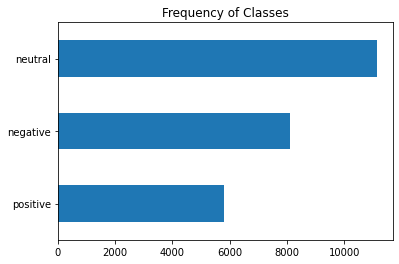

In [7]:
# Displaying the frequency of classes in the training data
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [8]:
# Resetting the dataset format
dataset.reset_format()

6. Tokenization

In [9]:
# Initializing the tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [10]:
# Defining tokenization function
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [11]:
# Applying the tokenize function across all the datasets (train/validation/test)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

7. Training a classifier (using feature extraction)

In [12]:
# The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states
model_checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_checkpoint).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# Extracting the last hidden states
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [14]:
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [15]:
# Extracting hidden states across all dataset splits in one go
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Here, the hidden state corresponding to each input text is available. Next step - create a feature matrix and train a classifier using the hidden states as the input features and the labels as the targets.

8. Creating a feature matrix

In [16]:
# Creating a feature matrix
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["valid"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["valid"]["label"])

X_train.shape, X_valid.shape

((25024, 768), (2781, 768))

9. Visualizaing the hidden state data before training a classifier

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


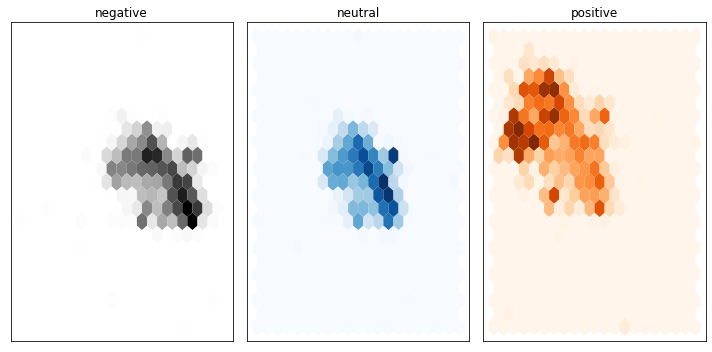

In [17]:
X_scaled = MinMaxScaler().fit_transform(X_train)          # Scaling features to [0, 1] range
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges"]
labels = dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

10. Training a logistic regression classifier using the hidden states and labels

In [33]:
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.4703344120819849

11. Print the confusion matrix for the dummy classifier

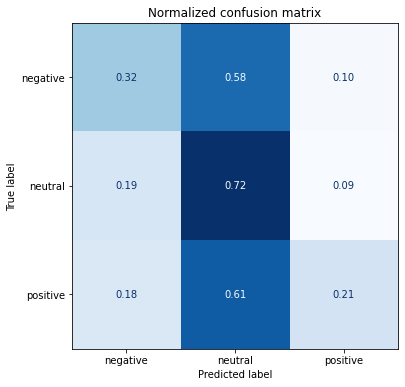

In [34]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fix, ax = plt.subplots(figsize=(6, 6))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  cm_display.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [36]:
from sklearn.metrics import classification_report

lr_clf_report = classification_report(y_valid, y_preds, target_names=labels)
print(lr_clf_report)

              precision    recall  f1-score   support

    negative       0.46      0.32      0.38       926
     neutral       0.49      0.72      0.58      1224
    positive       0.39      0.21      0.27       631

    accuracy                           0.47      2781
   macro avg       0.45      0.42      0.41      2781
weighted avg       0.46      0.47      0.44      2781



12. Save model

In [37]:
from joblib import dump, load

lr_clf_save_filename = "/content/drive/MyDrive/2022/College/COMP6321/saved_models/lr_clf.joblib"
dump(lr_clf, lr_clf_save_filename)

['/content/drive/MyDrive/2022/College/COMP6321/saved_models/lr_clf.joblib']

13. Load model

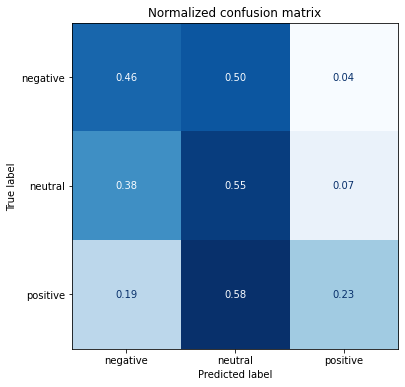

In [38]:
loaded_lr_clf = load(lr_clf_save_filename)

X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_test = np.array(dataset_hidden["test"]["label"])
y_preds_t = loaded_lr_clf.predict(X_test)
plot_confusion_matrix(y_preds_t, y_test, labels)

In [40]:
lr_clf_report = classification_report(y_valid, y_preds, target_names=labels, output_dict=True)
print(lr_clf_report)


{'negative': {'precision': 0.4622496147919877, 'recall': 0.32397408207343414, 'f1-score': 0.38095238095238093, 'support': 926}, 'neutral': {'precision': 0.4883203559510567, 'recall': 0.7173202614379085, 'f1-score': 0.5810721376571807, 'support': 1224}, 'positive': {'precision': 0.38922155688622756, 'recall': 0.20602218700475436, 'f1-score': 0.2694300518134715, 'support': 631}, 'accuracy': 0.4703344120819849, 'macro avg': {'precision': 0.446597175876424, 'recall': 0.415772176838699, 'f1-score': 0.4104848568076777, 'support': 2781}, 'weighted avg': {'precision': 0.45715428312717854, 'recall': 0.4703344120819849, 'f1-score': 0.4437269197945324, 'support': 2781}}
